Author: **Simone Puel** (spuel@utexas.edu) 

Title Manuscript: ***A Mixed, Unified Forward/Inverse Framework for Earthquake Problems: Fault Implementation and Coseismic Slip***

# Crack Mode II: Comparison between Mixed Finite-Elements and Displacement Elastic Formulations and Convergence Rates Computation

Here we provide the analytic expressions of the displacement and stress fields for a crack mode II following Pollard and Segall (1987) and used in this study. We consider a 2D domain and a shear crack of unity width, $2a = 1$, where $a$ is the half-width of the crack. The formulas below are expressed in polar coordinates centred at the crack middle $(x_0,y_0)$ and tips $a$. Following Pollard and Segall (1987), we can define the polar coordinates as (eqs. 8.29 and 8.31):

\begin{align}
\begin{aligned}[c]
r_1 &= \sqrt{\big[ x - (x_0 - a) \big]^2 + \big( y - y_0 \big)^2 } \\ 
r_2 &= \sqrt{\big[ x - (x_0 + a) \big]^2 + \big( y - y_0 \big)^2 } \\
r &= \sqrt{\big( x - x_0 \big)^2 + \big( y - y_0 \big)^2 } \\
R &= \sqrt{r_1 r_2}
\end{aligned}
\qquad\qquad
\begin{aligned}[c]
\theta_1 &= \arctan\big[ \frac{y - y_0}{x - (x_0 - a)} \big] \\
\theta_2 &= \arctan\big[ \frac{y - y_0}{x - (x_0 + a)} \big] \\
\theta &= \arctan\big[ \frac{y - y_0}{x - x_0} \big] \\
\Theta &= \frac{\theta_1 + \theta_2}{2}
\end{aligned}
\end{align}

Given a shear driving stress $\Delta \sigma_{II}$ and an elastic material with shear modulus $\mu$, the two components of the displacement field caused by relative motion of the crack walls are (eq. 8.33):

\begin{align}
u_x &= \frac{\Delta \sigma_{II}}{2\mu} \big\{ 2\big( 1-\nu \big) \big[ R \sin{\Theta} - r \sin{\theta} \big] + r \sin{\theta} \big[ \frac{r}{R} \cos{(\theta - \Theta)} - 1 \big] \big\}  \\
u_{y} &= -\frac{\Delta \sigma_{II}}{2\mu} \big\{ \big( 1-2\nu \big) \big[ R \cos{\Theta} - r \cos{\theta} \big] + r \sin{\theta} \big[ \frac{r}{R} \sin{(\theta - \Theta)} \big] \big\} 
\end{align}

We apply a unity driving stress, which leads to an elliptical solution for slip in the form of (eq. 8.34):

\begin{align}
\Delta u = \Delta \sigma_{II} \frac{1-\nu}{\mu} \sqrt{a^2 - (x_{crack}-x_0)^2}    
\end{align}

where $\nu$ is the Poisson's ratio of the elastic material, and $x_{crack}$ is the x-coordinate along the crack such that $|x_{crack}| \leq a$. 
Lastly, the three independent components of the stress field can be written as (eq. 8.44):

\begin{align}
\sigma_{xx} &= \sigma^r_{xx} + \Delta \sigma_{II} \big[ \frac{2r}{R} \sin{(\theta - \Theta)} - a^2 \frac{r}{R^3} \sin{\theta} \cos{(3\Theta)} \big] \\
\sigma_{xy} &= \sigma^r_{xy} + \Delta \sigma_{II} \big[ \frac{r}{R} \cos{(\theta - \Theta)} -1 - a^2 \frac{r}{R^3} \sin{\theta} \sin{(3\Theta)} \big] \\
\sigma_{yy} &= \sigma^r_{yy} + \Delta \sigma_{II} \big[ a^2 \frac{r}{R^3} \sin{\theta} \cos{(3\Theta)} \big]
\end{align}

where $\sigma^r_{xx}, \sigma^r_{xy}$ and $\sigma^r_{yy}$ are the corresponding remote/background stresses that act even in absence of the crack.

## Import Python Libraries

In [1]:
from __future__ import print_function, absolute_import, division

# Import FEniCS
import dolfin as dl
import ufl # not necessary, since DOLFIN already contains the 'ufl' (Unified Form Language)
import numpy as np
import math
import time

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
# Latex style in the plots
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=TINY_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

## Define Material Properties

In [2]:
# Define physical parameters (shear modulus - mu, and Lame parameter - lam)
mu = 1.0
lam = 1.0

# Print the physical parameters
print( "mu = %.1f; lambda = %.1f" % (mu, lam) )

mu = 1.0; lambda = 1.0


## Displacement Elastic Formulation (DF) with Split Node Technique for Fault

The equations governing small elastic deformations of a body $\Omega$ can be written as:

$$ 
\left\{
\begin{array}{ll}
\nabla \cdot \sigma = -f   & \text{in} \; \Omega, \\
\sigma = 2\mu\varepsilon + \lambda tr(\varepsilon) I  & \text{in} \; \Omega \\
\varepsilon = \frac{1}{2} (\nabla u + (\nabla u)^T) & \text{in} \; \Omega \\
u = u_0 & \text{on} \; \Gamma_{D} \\
\nabla u \cdot \boldsymbol{n} = t & \text{on} \; \Gamma_N
\end{array}
\right.
$$

where $\sigma$ is the stress tensor, $f$ is the body force per unit volume, $\lambda$ and $\mu$ are Lame's elastic parameters for the material in $\Omega$, $I$ is the identity tensor, $tr()$ is the trace operator on a tensor, $\varepsilon$ is the symmetric strain-rate tensor (symmetric gradient), and $u$ is the displacement vector field. We have here assumed isotropic elastic conditions.

To obtain the weak form we define the functional space $\Upsilon = \{ \upsilon \in H^1_0 (\Omega, \mathbb{V}) : \upsilon = 0$ on $\Gamma_N \}$, where $\mathbb{V}$ is the linear space of vectors.
Then we multiply the strong form by an arbitrary function $\upsilon \in \mathbb{V}$ and integrate over $\Omega$:

$$
\int_\Omega (\nabla \cdot \sigma) \, \upsilon \, dx = - \int_\Omega f \, \upsilon \, dx, \quad \forall v \in \mathbb{V} 
$$

Since $\nabla \cdot \sigma$ contains second-order derivatives of the primary unknown $u$, we integrate this term by part:

$$
\int_\Omega (\nabla \cdot \sigma) \, \upsilon \, dx = -\int_\Omega \sigma : \nabla \upsilon \, dx + \int_{\partial \Omega} (\sigma \cdot \boldsymbol{n}) \,\upsilon \, ds
$$

where the colon operator is the inner product between tensors (summed pairwise product of all elements), and $n$ is the outward unit normal at the boundaries. The quantity $\sigma \cdot \boldsymbol{n} = t$ is known as the traction or stress vector at the boundaries, and is often prescribed as a boundary condition (in this case as Neumann boundary condition, $\Gamma_N$). The Dirichlet boundary condition, that is the prescribed displacement $u_0$, has to be enforced in the function space. We thus obtain:

$$
\int_\Omega \sigma : \nabla \upsilon \, dx = \int_\Omega f \, \upsilon \, dx + \int_{\partial \Omega} t \,\upsilon \, ds
$$

One can show that the inner product of a symmetric tensor and an anti-symmetric tensor vanishes. If we express $\nabla v$ as a sum of its symmetric and anti-symmetric parts, only the symmetric part will survive in the product $\sigma : \nabla v$ since $\sigma$ is a symmetric tensor. Thus replacing $\nabla v$ by the symmetric gradient $\varepsilon(v) = \frac{1}{2} (\nabla u + (\nabla u)^T)$ gives the slightly different variational form:

$$
\int_\Omega \sigma : \varepsilon(\upsilon) \, dx = \int_\Omega f \, \upsilon \, dx + \int_{\partial \Omega} t \,\upsilon \, ds
$$

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$. The vector function space $\Upsilon$ is approximated by $\Upsilon_h = CG_k(\mathcal{T}_h, \mathbb{V})$, which are the $k$-th order continuous piecewise polynomials belonging to the Lagrange elements. 

The finite element approximation is: find $u_h \in \Upsilon_h$ such that:

$$
\int_\Omega \sigma_h : \varepsilon(\upsilon) \, dx = \int_\Omega f \, \upsilon \, dx + \int_{\partial \Omega} t \,\upsilon \, ds
$$


***Split node technique (Melosh and Raefsky, 1981)*** 

Given the discretized global matrix-vector system: $Ku = F$, where $K$ is the global stiffness matrix, $u$ is the unknown displacement field, and $F$ is the force vector, the split node technique modifies the global system at the local element level around the fault discontinuity. Given two adjacent elements at the two sides of the discontinuity, $1$ and $2$, the fully assembled system of equations becomes:

\begin{align}
\begin{pmatrix}
K^1_{11} & K^1_{12} & 0 \\
K^1_{21} & K^1_{22} + K^2_{11} & K^2_{12} \\
0 & K^2_{21} & K^2_{22}
\end{pmatrix}
\begin{pmatrix}
u_1 \\
u_2 \\
u_3
\end{pmatrix} = 
\begin{pmatrix}
F_1 - K^1_{12} \Delta u^1_2 \\
F_2 - K^1_{22} \Delta u^1_2 - K^2_{11} \Delta u^2_1  \\
F_3 - K^2_{21} \Delta u^2_1 
\end{pmatrix}
\end{align}

Note that splitting induces fictitious forces on the nodes adjacent to the split node. Following Melosh & Raefsky (1981), we implement the split node technique by modifying the global matrix-vector system around the fault discontinuity.

In what follow, we will let $\Omega := [0,4]\times[0,4]$ be a square domain, $\Gamma_D := \{ (x,y) \in \partial\Omega \}$ be the union of top, bottom, left and right boundaries with $u_0 = u_{an}$. We include a crack in the middle of width $2a = 1$ and prescribe a stress drop $\Delta \sigma = 1$ to give a left-lateral movement.

In [3]:
def SolveElasticDF(N, k, solver='mumps'):
    # Define parameters for the split node technique
    mid = length/2.0
    dcell = length/N
    tol = dcell/100.0
    # Define the triangular mesh
    xmin = 0.0; xmax = length
    ymin = 0.0; ymax = height
    mesh = dl.RectangleMesh(dl.Point(xmin, ymin), dl.Point(xmax, ymax), N, int(N), mesh_style)

    # Extract the dimension of the mesh (2D)
    dim = mesh.topology().dim()
    # Define the mesh boundaries
    boundaries = dl.MeshFunction("size_t", mesh, dim-1)

    # Define the top boundary. Check whether x is close to "height" (to within DOLFIN_EPS = 3e-16)
    class Top_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], height, dl.DOLFIN_EPS) and on_boundary

    class Bottom_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], 0.0, dl.DOLFIN_EPS) and on_boundary

    class Left_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], 0.0, dl.DOLFIN_EPS) and on_boundary

    class Right_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], length, dl.DOLFIN_EPS) and on_boundary

    class Fault_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], height/2.) and dl.between(x[0], (mid-a, mid+a))

    # Mark boundaries
    boundaries.set_all(0)
    Top_boundary().mark(boundaries, 1)
    Bottom_boundary().mark(boundaries, 2)
    Left_boundary().mark(boundaries, 3)
    Right_boundary().mark(boundaries, 4)
    Fault_boundary().mark(boundaries, 5)
    # Rename boundaries
    top = 1
    bottom = 2
    left = 3
    right = 4
    fault = 5
    # Define the surface integration over the external boundary (ds) and internal boundary (dS)
    ds = dl.Measure("ds")(domain=mesh, subdomain_data=boundaries)
    dS = dl.Measure("dS")(domain=mesh, subdomain_data=boundaries)

    # Define the two subdomains for the split node technique
    class Omega_0(dl.SubDomain):
        def inside(self, x, on_boundary):
            return x[1] > height/2.0-tol and x[1] < height/2.0+2*dcell+tol and x[0] < mid+a+tol and x[0] > mid-a-tol

    class Omega_1(dl.SubDomain):
        def inside(self, x, on_boundary):
            return x[1] > height/2.0-2.0*dcell-tol and x[1] < height/2.0+tol and x[0] < mid+a+tol and x[0] > mid-a-tol

    # Mark the two subdomains
    mf = dl.MeshFunction("size_t", mesh, dim)
    subdomain0 = Omega_0()
    subdomain1 = Omega_1()
    mf.set_all(0)
    subdomain0.mark(mf, 1)
    subdomain1.mark(mf, 2)
    # Define the integration area of the two subdomains
    dxx = dl.Measure("dx")(domain=mesh, subdomain_data=mf)

    ### CLASSIC DISPLACEMENT FORMULATION ###
    # Define functions for displacement formulation
    def epsilon(u):
        eps = 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
        # otherwise: eps = ufl.sym(ufl.grad(u))
        return eps

    def stress(u):
        sigma = 2.0*mu*epsilon(u) + lam*ufl.nabla_div(u)*ufl.Identity(dim) 
        # otherwise: sigma = 2.0*mu*epsilon(u) + lam*ufl.tr(epsilon(u))*ufl.Identity(dim)
        return sigma

    # Define function spaces. "CG" states for "Continuous Galerkin" FE, which are continuous polynomial functions
    V_df = dl.VectorFunctionSpace(mesh, 'CG', k)
    # Define trial and test functions
    u_df = dl.TrialFunction(V_df)
    v_df = dl.TestFunction(V_df)

    # Define the slip along the crack (look at Pollard & Segall, 1987)
    slip = dl.Expression( "-(s*2*(1-nu)/mu)/2* sqrt( pow(a,2) - pow(x[0]-mid,2) )", s=sII, nu=nu, mu=mu, a=a, mid=mid, degree=5 )
    slip1 = dl.Expression( "(s*2*(1-nu)/mu)/2* sqrt( pow(a,2) - pow(x[0]-mid,2) )", s=sII, nu=nu, mu=mu, a=a, mid=mid, degree=5 )

    # Apply Dirichlet BCs:
    bc_df = [ dl.DirichletBC(V_df, u_0, boundaries, left),
              dl.DirichletBC(V_df, u_0, boundaries, right),
              dl.DirichletBC(V_df, u_0, boundaries, top),
              dl.DirichletBC(V_df, u_0, boundaries, bottom) ]

    # Perform the split node technique (Melosh & Raefesky, 1981)
    utmp1 = dl.Function(V_df)
    utmp2 = dl.Function(V_df)
    # Apply the Dirichlet BCs to prescribe slip in the displacement field along the crack
    du1 = dl.DirichletBC(V_df.sub(0), slip1, boundaries, fault)
    du2 = dl.DirichletBC(V_df.sub(0), slip, boundaries, fault)
    du1.apply(utmp1.vector())
    du2.apply(utmp2.vector())

    # Write the weak form for the standard displacement elastic formulation
    J_df = dl.inner(stress(u_df), epsilon(v_df))*dl.dx
    J_df += - dl.inner(f, v_df)*dl.dx
    # Apply K*du as the force vector F in: K*u = F (for the two subdomains)
    J_df += - dl.inner( stress(utmp1), epsilon(v_df) )*dxx(1) \
            - dl.inner( stress(utmp2), epsilon(v_df) )*dxx(2)

    # Let FEniCS separates the variational form into a bilinear form LHS and the linear form RHS
    a_df, L_df = dl.lhs(J_df), dl.rhs(J_df)
    # Solve the linear system
    u_df = dl.Function(V_df)
    dl.solve(a_df==L_df, u_df, bc_df,
            solver_parameters={'linear_solver': solver})

    # Calculate stress field a posteriori. Define a tensor function space since the stress is a tensor.
    # Use "DG" (Discontinuous Galerkin), since the stress is constant within the cell.
    Vsig = dl.TensorFunctionSpace(mesh, "DG", k-1)
    # Make a mixed Functionspace just for the dofs
    ME_element = dl.MixedElement([Vsig.ufl_element(), V_df.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    # Create a zero function
    sigma_df = dl.Function(Vsig)
    # Assign the stress calculation to the empty function just created.
    sigma_df.assign(dl.project(stress(u_df), Vsig))
    # Print the DOFs of stress and displacements for the displacement formulation.
    print( "Number of STATE dofs: STRESS = {0}, DISPLACEMENT = {1}".format(Vu.sub(0).dim(), Vu.sub(1).dim()) )

    # Compute error for displacement and stress around a dx around the crack
    dx_errors = get_dx_for_error_evaluation(mesh, ccell)
    err_L2_u = math.sqrt( dl.assemble(dl.inner(u_ex - u_df, u_ex - u_df)*dx_errors) )
    err_E_sigma = math.sqrt( dl.assemble( dl.inner(sigma_ex - sigma_df, sigma_ex - sigma_df)*dx_errors ) ) 
    # Compute error in the entire domain
    dx = get_dx_for_error_evaluation(mesh, dcell)
    err_L2_u_domain = math.sqrt( dl.assemble(dl.inner(u_ex - u_df, u_ex - u_df)*dx) )
    err_E_sigma_domain = math.sqrt( dl.assemble( dl.inner(sigma_ex - sigma_df, sigma_ex - sigma_df)*dx ) ) 
    

    return Vu, u_df, sigma_df, err_L2_u, err_E_sigma, err_L2_u_domain, err_E_sigma_domain

## Mixed Finite Element Elastic Formulation (MF) with Fault Implementation

The linear spaces of vectors, matrices, symmetric matrices and skew-symmetric matrices are denoted by $\mathbb{V}$, $\mathbb{M}$, $\mathbb{S}$ and $\mathbb{K}$, respectively.
For a domain $\Omega \subset \mathbb{R}^d, d=2,3$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, we write the boundary value problem (BVP):

$$ 
\left\{
\begin{array}{ll}
A\sigma = \nabla u - r   & \text{in} \; \Omega \\
- \nabla \cdot \sigma = f   & \text{in} \; \Omega \\
u = u_0 & \text{on} \; \Gamma_D \\
\sigma \cdot \boldsymbol{n} = t & \text{on} \; \Gamma_N \\
[\![T(n_{\Gamma_F}) u ]\!] = s & \text{on} \; \Gamma_F \\
[\![ u \cdot n_{\Gamma_F} ]\!] = 0 & \text{on} \; \Gamma_F \\
[\![ \sigma \cdot n_{\Gamma_F} ]\!] = 0 \; & \text{on} \; \Gamma_F
\end{array}
\right.
$$

where $A = A(x)$ is the fourth-order elastic compliance tensor describing the material properties of the medium. $r$ is the skew-symmetric part of the gradient deformation tensor $\nabla u$, $f$ are the body forces, $u_0$ is the imposed displacement values at the boundaries, $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$, and $t$ is the traction. The last three conditions represent the constraints on the fault discontinuity. 
$[\![ \phi ]\!] = \phi^+ - \phi^-$ is the jump operator, and $T(n_{\Gamma_F})$ is a tangent operator allowing to take the component of the displacement $u$ parallel to the fault plane $\Gamma_F$. $s$ is the fault slip and $n_{\Gamma_F} = n^{+} = - n^-$ is the unit normal vector fields on $\Gamma_F$.

The difference with respect the classic displacement elastic formulation is that we wrote the $4^{th}$ order elastic tensor $C$ as its compliance tensor $A$, assuming that its inverse exists. Moreover, the strain tensor $\varepsilon = sym(\nabla u)$ can be written as the difference between the gradient deformation tensor and the skew-symmetric part (seen as a rotation component $r$). In this case, we do have three unknowns (stress, displacement and rotation). This formulation seems to work better close to material incompressiblity conditions.

The material properties are described at each point $x \in \Omega$ by a compliance tensor $A = A(x)$, which is a symmetric, bounded and uniformly positive definite linear operator. As an example, in the case of a homogeneous and isotropic body, the elastic compliance tensor becomes:

$$
A\sigma = \frac{1}{2\mu} \bigg( \sigma - \frac{\lambda}{2\mu + d\lambda} tr(\sigma) I  \bigg)  
$$

where $I$ is the $d \times d$ identity matrix and $\mu > 0, \lambda > −2\mu/d$ are the Lame coefficients.

To obtain the weak form we define the functional spaces: $\Sigma = \{ \tau \in H (\nabla \cdot, \Omega, \mathbb{M}) : \tau \, n = 0 \}$ on  $\Gamma_N$, $W = L^2 (\Omega, \mathbb{R}^d)$, $\Xi = L^2 (\Omega, \mathbb{K})$, which represent the space of square-integrable matrices fields with square-integrable divergence satisfying the traction boundary conditions, and the spaces of all square integrable vector fields.

Then we multiply the strong form by arbitrary functions $\tau \in \Sigma, \, \omega \in W, \, \xi \in \Xi$ and integrate over $\Omega$:

\begin{align}
\int_\Omega A\sigma : \tau \, dx - \int_\Omega \nabla u \, \tau \, dx + \int_\Omega r \, as(\tau) \, dx &= 0, &\quad \forall \tau \in \Sigma \\ 
- \int_\Omega \nabla \cdot \sigma \, \omega \, dx &= \int_\Omega f \, \omega \, dx, &\quad \forall \omega \in W \\
\int_\Omega as(\sigma) \, \xi \, dx &= 0, &\quad \forall \xi \in \Xi
\end{align}

We define the asymmetry operator $\text{as}(\tau) = \frac{1}{2}(\tau - \tau^T) = (\tau_{12} - \tau_{21})$ in 2D and $\text{as}(\tau) = (\tau_{32} - \tau_{23}, \tau_{31} - \tau_{13}, \tau_{21} - \tau_{12})^T$ in 3D. Note that the Lagrange multiplier $r$ is a scalar and vector field in 2D and 3D, respectively. The third equation acts as a Lagrange multiplier to impose the symmetry of the stress tensor. 

The integration by parts of the non-conforming term in the first equation (constitutive relation) gives:

$$ 
\int_\Omega A\sigma : \tau \, dx + \int_\Omega u \, \nabla \cdot \tau \, dx + \int_\Omega r \, as(\tau) \, dx =
\int_{\partial\Omega} u_0 \, (\tau \cdot \boldsymbol{n}) \, ds + \int_{\Gamma_F} [\![ u \cdot (\tau \, n) ]\!] \, dS
$$

where $ds$ and $dS$ represent the integration of the integrand over the external and internal boundaries, respectively.
Looking at the variational form, we see that the boundary condition for the flux ($\sigma \cdot \boldsymbol{n} = t$) is now an essential boundary condition (which should be enforced in the function space), while the other boundary condition ($u = u_0$) becomes a natural boundary condition (which should be prescribed into the variational form).

Decomposing the last term into its normal and tangential (relative to the fault $\Gamma_F$) components results in:

\begin{align}
\int_{\Gamma_F} [\![ u \cdot (\tau \, n) ]\!] \, dS &= \int_{\Gamma_F} [\![ T(n) u \cdot T(n) (\tau \, n) ]\!] \, dS + \int_{\Gamma_F} u \cdot n \, [\![ (\tau \, n) \cdot n ]\!] \, dS \\
&= \int_{\Gamma_F} s \cdot T(n) (\tau \, n) \, dS
\end{align}

where we have used the slip definition and the fact that $\tau \in \Sigma$ to obtain the last equality.
Hence, the variational formulation of the elasticity equation in this mixed form reads: seek $(\sigma, u, r) \in \Sigma \times W \times \Xi$ such that:

\begin{align}\label{eq:weak_form_fault}
\int_{\Omega} A\sigma : \tau \,dx + \int_{\Omega} u \cdot (\nabla \cdot \tau) \,dx + \int_{\Omega} \text{as}(\tau) \cdot r \,dx &= \int_{\Gamma_F} s \cdot \big[ T(n^+) (\tau^+ \,n^+) \big] \,dS &\forall \tau &\in \Sigma  \\
\int_{\Omega} (\nabla \cdot \sigma) \cdot \omega \,dx &= - \int_{\Omega} f \cdot \omega \,dx &\forall \omega &\in W  \\
\int_{\Omega} \text{as}(\sigma) \cdot \xi \,dx &= 0 &\forall \xi &\in \Xi 
\end{align}

where we use the superscript "$^+$" to indicate the side of the fault where the slip is prescribed. In this scenario, the slip $s$ will be negative for a thrust fault and positive for a normal movement. Vice-versa, we could also write a negative superscript for the unit normal, but in this case we would need to take a positive sign of the slip to indicate a reverse movement.  

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and we define a mixed finite dimensional subspace $\Sigma_h \times W_h \times \Xi_h$ consisting of globally continuous functions that are piecewise polynomial on each element of $\mathcal{T}_h$. In particular $\Sigma_h = BDM_k (\mathcal{T}_h, \mathbb{V}); \quad W_h = DG_{k-1} (\mathcal{T}_h, \mathbb{V}); \quad \Xi_h = DG_{k-1} (\mathcal{T}_h, \mathbb{K})$, where $BDM_k$ represents the $k$'th order of Brezzi-Douglas-Marini elements which are vector polynomials with continuity of normal components over inter-element facets, and $DG_{k-1}$ are piecewise discontinuous Galerkin elements.

The mixed finite element approximation is: find $(\sigma_h, u_h, r_h) \in \Sigma_h \times W_h \times \Xi_h$ such that:

\begin{align}
\int_{\Omega_h} A\sigma_h : \tau \,dx + \int_{\Omega_h} u_h \cdot (\nabla \cdot \tau) \,dx + \int_{\Omega_h} \text{as}(\tau) \cdot r_h \,dx &= \int_{\Gamma_{h,F}} s \cdot \big[ T(n^+) (\tau^+ \,n^+) \big] \,dS &\forall \tau &\in \Sigma_h \\
\int_{\Omega_h} (\nabla \cdot \sigma_h) \cdot \omega \,dx &= - \int_{\Omega_h} f \cdot \omega \,dx &\forall \omega &\in W_h  \\
\int_{\Omega_h} \text{as}(\sigma_h) \cdot \xi \,dx &= 0 &\forall \xi &\in \Xi_h 
\end{align}

where $\Omega_h$ is the discretized domain. The mesh is fitted to the fault location, that is $\Gamma_{h,F}$ is the union of facets which align with the fault geometry in the triangulation of $\Omega_h$.

In what follow, we will let $\Omega := [0,4]\times[0,4]$ be a rectangular domain, $\Gamma_D := \{ (x,y) \in \partial\Omega \}$ be the union of top, bottom, left and right boundaries with $u_0 = u_{an}$. We include a crack in the middle of width $2a = 1$ and prescribe a stress drop $\Delta \sigma = 1$ to give a left-lateral movement.

In [4]:
def SolveElasticMF(N, k, solver='mumps'):
    # Define parameters for the split node technique
    mid = length/2.0
    dcell = length/N
    tol = dcell/100.0
    # Define the triangular mesh
    xmin = 0.0; xmax = length
    ymin = 0.0; ymax = height
    mesh = dl.RectangleMesh(dl.Point(xmin, ymin), dl.Point(xmax, ymax), N, int(N), mesh_style)

    # Extract the dimension of the mesh (2D)
    dim = mesh.topology().dim()
    # Define the mesh boundaries
    boundaries = dl.MeshFunction("size_t", mesh, dim-1)

    # Define the boundaries. Check whether x is close to "height" (to within DOLFIN_EPS = 3e-16)
    class Top_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], height, dl.DOLFIN_EPS) and on_boundary

    class Bottom_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], 0.0, dl.DOLFIN_EPS) and on_boundary

    class Left_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], 0.0, dl.DOLFIN_EPS) and on_boundary

    class Right_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], length, dl.DOLFIN_EPS) and on_boundary

    class Fault_boundary(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], height/2.) and dl.between(x[0], (mid-a, mid+a))

    # Mark boundaries
    boundaries.set_all(0)
    Top_boundary().mark(boundaries, 1)
    Bottom_boundary().mark(boundaries, 2)
    Left_boundary().mark(boundaries, 3)
    Right_boundary().mark(boundaries, 4)
    Fault_boundary().mark(boundaries, 5)
    # Rename boundaries
    top = 1
    bottom = 2
    left = 3
    right = 4
    fault = 5
    # Define the surface integration over the external boundary (ds) and internal boundary (dS)
    ds = dl.Measure("ds")(domain=mesh, subdomain_data=boundaries)
    dS = dl.Measure("dS")(domain=mesh, subdomain_data=boundaries)

    ### MIXED FE FORMULATION OF ELASTICITY WITH WEAK SYMMETRY OF STRESS ###
    # Define functions for stress-displacement-rotation formulation
    # Define the Compliance matrix for elasticity
    def Asigma(s):
        A = 1.0/(2.0*mu)*(s - lam/(2.0*mu + dim*lam)*dl.tr(s)*dl.Identity(dim))
        return A

    # Define the asymmetry operator
    def asym(s): # Calculate the off-diagonal difference. If != 0 --> asymmetry
        if dim == 2:
            as_ = s[0,1] - s[1,0]
        return as_

    # Define the tangent at the fault plane
    def tangent(n):
        tangent = dl.as_vector( [ n[1], -n[0] ] )
        return tangent

    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)  # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1) # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)       # rotation (scalar field)
    # Create a mixed fine element function space
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    # Calculate the unit normal of ∂Ω pointing outside Ω
    n = dl.FacetNormal(mesh)
    # Print the number of the degrees of freedom
    print( "Number of STATE dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim()) )

    # Define slip expression along the crack
    slip = dl.Expression( "(s*2*(1-nu)/mu)* sqrt( pow(a,2) - pow(x[0]-mid,2) )", s=sII, nu=nu, mu=mu, a=a, mid=mid, degree=5 )

    # Define trial and test functions
    (sigma_mf, u_mf, r_mf) = dl.TrialFunctions(Vu)    
    (tau, w, q) = dl.TestFunctions(Vu)

    # Weak Formulation elasticity
    J_mf = dl.inner(Asigma(sigma_mf), tau)*dl.dx \
        + dl.inner(dl.div(tau), u_mf)*dl.dx \
        + dl.inner(asym(tau), r_mf)*dl.dx \
        + dl.inner(dl.div(sigma_mf), w)*dl.dx \
        + dl.inner(asym(sigma_mf), q)*dl.dx \
        - dl.inner(f, w)*dl.dx \
        - dl.inner(u_0, tau*n)*ds(top) \
        - dl.inner(u_0, tau*n)*ds(bottom) \
        - dl.inner(u_0, tau*n)*ds(left) \
        - dl.inner(u_0, tau*n)*ds(right)
    # Fault discontinuity implementation
    J_mf += - dl.inner( slip, dl.dot(tau('+')*n('+'), tangent(n)('+')) )*dS(fault)

    # Let FEniCS separates the variational form into a bilinear form LHS and the linear form RHS
    a_mf, L_mf = dl.lhs(J_mf), dl.rhs(J_mf)

    # Solve linear system
    U_mf = dl.Function(Vu)
    bc_mf = []
    dl.solve(a_mf == L_mf, U_mf, bc_mf,
            solver_parameters={'linear_solver': solver},
                                form_compiler_parameters={"optimize": True})
    
    # Split the results
    sigma_mf, u_mf, r_mf = U_mf.split(deepcopy=True)
    sigmaa_mf, sigmab_mf = sigma_mf.split(deepcopy=True)
    sigma_mf = dl.as_vector((sigmaa_mf, sigmab_mf))
    
    # Compute error for displacement and stress around a dx around the crack
    dx_errors = get_dx_for_error_evaluation(mesh, ccell)
    err_L2_u = math.sqrt( dl.assemble(dl.inner(u_ex - u_mf, u_ex - u_mf)*dx_errors) )    
    err_E_sigma = math.sqrt( dl.assemble( dl.inner(sigma_ex - sigma_mf, sigma_ex - sigma_mf)*dx_errors ) )
    # Compute error in the entire domain
    dx = get_dx_for_error_evaluation(mesh, dcell)
    err_L2_u_domain = math.sqrt( dl.assemble(dl.inner(u_ex - u_mf, u_ex - u_mf)*dx) )    
    err_E_sigma_domain = math.sqrt( dl.assemble( dl.inner(sigma_ex - sigma_mf, sigma_ex - sigma_mf)*dx ) )
    
    
    return Vu, u_mf, sigma_mf, mesh, err_L2_u, err_E_sigma, err_L2_u_domain, err_E_sigma_domain 

## Comparison of Numerical (DF and MF) and Exact Solution

In order to compare the exact solution and the numerical solutions using the two different elastic formulations, we choose the same mesh and same order of elements for displacement, that is "linear" piecewise continuous functions and "quadratic" elements.

**NOTE**: The degree-of-freedom for displacement for the two formulations are different. For ``DF``, we use Continuous Galerkin ($CG_1$ or Lagrange elements $P_1$, therefore $k = 1$), in which the dof are at the vertices. For ``MF``, we use Discontinuos Galerkin ($DG_1$, therefore $k =2$), in which the dof are close to the vertices but within the cells.

For the BCs, we have: $u_0 = u_{an}$ on $\Gamma_{top}, \Gamma_{bottom}, \Gamma_{left}$ and $\Gamma_{right}$, respectively.

In [5]:
# Choose the mesh size and the number of elements in each direction
N = 100
mesh_style = "right/left"
length, height = 4.0, 4.0
# Define material parameters
mu = 1.0
lam = 1.0
nu = lam/(2*(lam+mu))
E = 2*mu*(1+nu)
# Print the physical parameters
print( "mu = %.1f; lambda = %.1f; nu = %.2f; E = %.1f" % (mu, lam, nu, E) )

# Define crack parameters
ccell = 0.5        # dx around the crack to remove in the error calculation
a = 0.5            # crack half-width
sII = 1.0          # stress drop
x0 = length/2.0    # x crack center
y0 = height/2.0    # y crack center

# Write expressions for the analytic solution for the crack mode II (Pollard & Segall, 1987)
r1 = dl.Expression( "sqrt( pow(x[0]-(x0-a),2) + pow(x[1]-y0,2) )", degree=5, a=a, x0=x0, y0=y0 )
r2 = dl.Expression( "sqrt( pow(x[0]-(x0+a),2) + pow(x[1]-y0,2) )", degree=5, a=a, x0=x0, y0=y0 )
r = dl.Expression( "sqrt( pow(x[0]-x0,2) + pow(x[1]-y0,2) )", degree=5, x0=x0, y0=y0 )
Cr = dl.Expression( "sqrt( r1 * r2 )", degree=5, r1=r1, r2=r2 )
th1 = dl.Expression( "atan2( (x[1]-y0), (x[0]-(x0-a)) )", degree=5, a=a, x0=x0, y0=y0 )
th2 = dl.Expression( "atan2( (x[1]-y0), (x[0]-(x0+a)) )", degree=5, a=a, x0=x0, y0=y0 )
th = dl.Expression( "atan2( (x[1]-y0), (x[0]-x0) )", degree=5, x0=x0, y0=y0 )
Cth = dl.Expression( "0.5*( th1 + th2 )", degree=5, a=a, th1=th1, th2=th2 )
# Write the analytic exrpession for displacement
u_ex = dl.Expression( ("s/(2*mu)*( 2*(1-nu)*( Cr*sin(Cth) - r*sin(th) ) + r*sin(th)*( r/Cr*cos(th-Cth)-1 ) )",
                       "-s/(2*mu)*( (1-2*nu)*( Cr*cos(Cth) - r*cos(th) ) + r*sin(th)*( r/Cr*sin(th-Cth) ) )"),
                     degree=5, a=a, s=-sII, mu=mu, nu=nu, r=r, Cr=Cr, Cth=Cth, th=th )
# Write the analytic exrpession for stress
sigma_ex = dl.Expression( (("s*( 2*r/Cr* sin(th-Cth) - pow(a,2)*r/pow(Cr,3)*sin(th)*cos(3*Cth) )",
                        "s*( r/Cr*cos(th-Cth) -1 - pow(a,2)*r/pow(Cr,3)*sin(th)*sin(3*Cth) )"), 
                       ("s*( r/Cr*cos(th-Cth) -1 - pow(a,2)*r/pow(Cr,3)*sin(th)*sin(3*Cth) )",
                        "s*( pow(a,2)*r/pow(Cr,3) * sin(th)*cos(3*Cth) )" )),
                     degree=5, a=a, s=-sII, mu=mu, nu=nu, r=r, Cr=Cr, Cth=Cth, th=th )


# Impose body forces and boundary conditions 
f = dl.Constant( (0.0, 0.0) )
u_0 = u_ex 
s_0 = sigma_ex

# Create function to remove dx around the crack.
def get_dx_for_error_evaluation(mesh, d_cell_cc):
    dim = 2
    class AroundFaultEdges(dl.SubDomain):
        def inside(self, x, on_boundary):
            l = dl.between(x[0], (x0-a-d_cell_cc, x0-a+d_cell_cc))
            r = dl.between(x[0], (x0+a-d_cell_cc, x0+a+d_cell_cc))
            return (l or r) and dl.between(x[1], (y0-d_cell_cc, y0+d_cell_cc))
    
    # Marker the subdomain
    marker_errors = dl.MeshFunction("size_t", mesh, dim)
    aroundFaultEdges = AroundFaultEdges()
    marker_errors.set_all(1)
    aroundFaultEdges.mark(marker_errors, 2)
    my_dx = dl.Measure("dx", domain=mesh, subdomain_data=marker_errors)
    
    return my_dx(1)


# Solve the elastic system in the displacement formulation
k_df = 1
start_df = time.time()
V_df, u_df, sigma_df, err_L2_u_df, err_E_sigma_df, err_L2_u_df_domain, err_E_sigma_df_domain = SolveElasticDF(N, k_df, solver='mumps')
end_df = time.time()
run_time_df = end_df - start_df
print( "The run time for DF with k = {0} and N = {1} is: {2}".format(k_df, N, run_time_df) )
print( "The error of L2 and H1 norms are: Er_u = {0} and Er_sigma = {1}".format(err_L2_u_df, err_E_sigma_df) )
print( "The error of L2 and H1 norms in the domain are: Er_u = {0} and Er_sigma = {1}".format(err_L2_u_df_domain, err_E_sigma_df_domain) )
# Solve the elastic system in the mixed FE formulation
k_mf = 2
start_mf = time.time()
V_mf, u_mf, sigma_mf, mesh, err_L2_u_mf, err_E_sigma_mf, err_L2_u_mf_domain, err_E_sigma_mf_domain = SolveElasticMF(N, k_mf, solver='mumps')
end_mf = time.time()
run_time_mf = end_mf - start_mf
print( "The run time for MF with k = {0} and N = {1} is: {2}".format(k_mf, N, run_time_mf) )
print( "The error of L2 and H1 norms are: Er_u = {0} and Er_sigma = {1}".format(err_L2_u_mf, err_E_sigma_mf) )
print( "The error of L2 and H1 norms in the domain are: Er_u = {0} and Er_sigma = {1}".format(err_L2_u_mf_domain, err_E_sigma_mf_domain) )

mu = 1.0; lambda = 1.0; nu = 0.25; E = 2.5
Number of STATE dofs: STRESS = 80000, DISPLACEMENT = 20402
The run time for DF with k = 1 and N = 100 is: 1.6980891227722168
The error of L2 and H1 norms are: Er_u = 0.0011494789923828896 and Er_sigma = 0.020353266296365517
The error of L2 and H1 norms in the domain are: Er_u = 0.04644438819588315 and Er_sigma = 3.0821706730491143
Number of STATE dofs: STRESS=301200, DISPLACEMENT=120000, ROTATION=60000
The run time for MF with k = 2 and N = 100 is: 7.005577087402344
The error of L2 and H1 norms are: Er_u = 0.0009225264652665412 and Er_sigma = 0.004438171570037238
The error of L2 and H1 norms in the domain are: Er_u = 0.023980572045705494 and Er_sigma = 0.28022735241113866


## Plot Comparison Results

We first plot the results of the displacement field for a left-lateral shear movement along the crack. Then we plot the displacement magnitude and the normal stress between the pure elastic with the split node technique (DF) and mixed FE formulation with the fault implementation described above (MF).

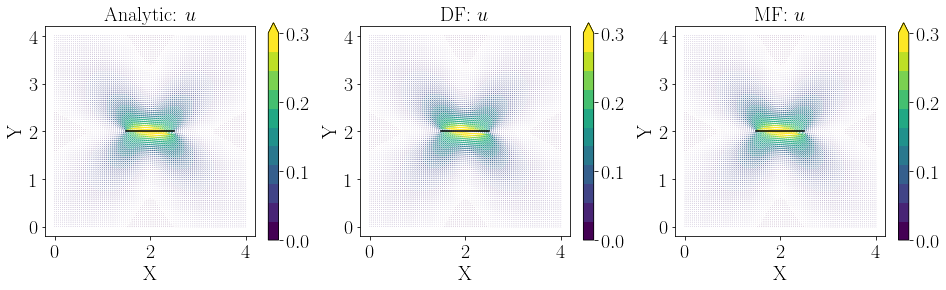

In [6]:
cmap = plt.get_cmap('viridis', 11)

plt.figure(figsize=(16,4))

plt.subplot(131)
p1 = dl.plot(u_ex, mesh=mesh, cmap=cmap)
plt.plot([x0-a, x0+a], [y0, y0], 'k')
p1.set_clim(0, 0.3)
cb = plt.colorbar(p1, extend='max')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r"Analytic: $u$", fontsize=20)

plt.subplot(132)
p2 = dl.plot(u_df, cmap=cmap)
plt.plot([x0-a, x0+a], [y0, y0], 'k')
p2.set_clim(0, 0.3)
cb = plt.colorbar(p2, extend='max')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r"DF: $u$", fontsize=20)

plt.subplot(133)
p3 = dl.plot(u_mf, cmap=cmap)
plt.plot([x0-a, x0+a], [y0, y0], 'k')
p3.set_clim(0, 0.3)
cb = plt.colorbar(p3, extend='max')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r"MF: $u$", fontsize=20)
plt.show()

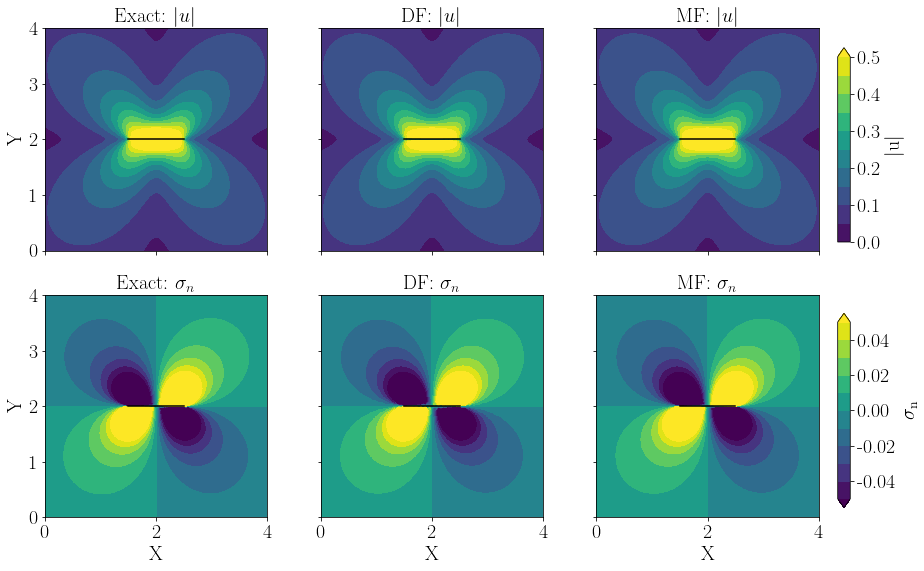

In [7]:
# Compute the displacement magnitude and normal stress 
norm_u_ex = dl.sqrt(dl.inner(u_ex, u_ex))
norm_u_df = dl.sqrt(dl.inner(u_df, u_df))
norm_u_mf = dl.sqrt(dl.inner(u_mf, u_mf))
sigma_N_ex = 0.5*(sigma_ex[0,0] + sigma_ex[1,1])
sigma_N_df = 0.5*(sigma_df[0,0] + sigma_df[1,1])
sigma_N_mf = 0.5*(sigma_mf[0,0] + sigma_mf[1,1])

# Calculate analytic solution for slip along crack mode II (Pollard & Segall, 1987)
x_crack = np.linspace(length/2-a, length/2+a, 5)
slip = -sII*(1-nu)/mu*np.sqrt( (a*np.ones(x_crack.shape))**2-(x_crack-length/2)**2 )
max_slip_ex = max(abs(slip))
# Calculate the maximum normal stress for normalization
norm_sigma_N_ex_interpolate = dl.project(sigma_N_ex, dl.FunctionSpace(mesh, 'CG', k_df))
sigma_N_ex_norm = norm_sigma_N_ex_interpolate.compute_vertex_values(mesh)
max_sigma_N_ex = np.max(np.abs(sigma_N_ex_norm))

# Choose levels for colorbar
levels_u = np.linspace(0, 0.5, 11)
levels_sigma = np.linspace(-0.05, 0.05, 11)

# Choose the colormaps
cmap = "viridis"

# Plot comparison of displacement magnitude
# Plot |u|
fig = plt.figure(figsize=(14,9))
left = 0.915; width = 0.0125; height1 = 0.3

plt.subplot(231)
CS_1 = dl.plot(norm_u_ex/max_slip_ex, mesh=mesh, levels=levels_u, cmap=cmap, extend='max')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
plt.ylabel('Y')
ax.set_rasterized(True)
plt.title( r"Exact: $|u|$" )

# left, top, width, height
cbar_ax_1 = plt.gcf().add_axes([left, 0.55, width, height1])
cbar1 = plt.colorbar(CS_1, cax=cbar_ax_1, orientation="vertical", format="%.1f",
                    label=r'$|\mathrm{u}|$')
cbar_ax_1.xaxis.set_ticks_position('top')
cbar_ax_1.xaxis.set_label_position('top')

ax = plt.subplot(232)
CS_2 = dl.plot(norm_u_df/max_slip_ex, levels=levels_u, cmap=cmap, extend='max')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_rasterized(True)
plt.title( r"DF: $|u|$" )

plt.subplot(233)
CS_3 = dl.plot(norm_u_mf/max_slip_ex, levels=levels_u, cmap=cmap, extend='max')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_rasterized(True)
plt.title( r"MF: $|u|$" )


# Plot normal stress
plt.subplot(234)
CS_4 = dl.plot(sigma_N_ex/max_sigma_N_ex, mesh=mesh, levels=levels_sigma, cmap=cmap, extend='both')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel('X')
plt.ylabel('Y')
ax.set_rasterized(True)
plt.title( r"Exact: $\sigma_n$" )

# left, top, width, height
cbar_ax_4 = plt.gcf().add_axes([left, 0.14, width, height1])
cbar4 = plt.colorbar(CS_4, cax=cbar_ax_4, orientation="vertical", format="%.2f",
                    label=r'$\mathrm{\sigma_n}$')
cbar_ax_4.xaxis.set_ticks_position('top')
cbar_ax_4.xaxis.set_label_position('top')

plt.subplot(235)
CS_5 = dl.plot(sigma_N_df/max_sigma_N_ex, levels=levels_sigma, cmap=cmap, extend='both')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
plt.xlabel('X')
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.yaxis.set_ticklabels([])
ax.set_rasterized(True)
plt.title( r"DF: $\sigma_n$" )

plt.subplot(236)
CS_6 = dl.plot(sigma_N_mf/max_sigma_N_ex, levels=levels_sigma, cmap=cmap, extend='both')
plt.plot([x0-a, x0+a], [y0, y0], 'k')
plt.xlabel('X')
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.yaxis.set_ticklabels([])
ax.set_rasterized(True)
plt.title( r"MF: $\sigma_n$" )

plt.show()

## Calculate Convergence Rate

The degree-of-freedom for displacement for the two formulations are different. For ``DF``, we use Continuous Galerkin ($CG_1$ or Lagrange elements $P_1$, therefore $k = 1$), in which the dof are at the vertices for **linear** elements, and $CG_2$ or Lagrange elements $P_2$, therefore $k = 2$ for **quadratic** elements. For ``MF``, we use Discontinuos Galerkin ($DG_1$, therefore $k =2$), in which the dof are close to the vertices but within the cells for **linear** elements for displacements and $DG_2$ ($k = 3$) for **quadratic** elements.

In [8]:
# Create a subroutine to calculate the convergence rate.
def make_convergence_rate(N, k_df, k_mf, solver='mumps'):
    errs_L2_u_df = np.zeros(N.shape)
    errs_L2_u_mf = np.zeros(N.shape)
    errs_E_sigma_df = np.zeros(N.shape)
    errs_E_sigma_mf = np.zeros(N.shape)
    errs_L2_u_df_domain = np.zeros(N.shape)
    errs_L2_u_mf_domain = np.zeros(N.shape)
    errs_E_sigma_df_domain = np.zeros(N.shape)
    errs_E_sigma_mf_domain = np.zeros(N.shape)
    run_time_df = np.zeros(N.shape)
    run_time_mf = np.zeros(N.shape)
    dof_u_df = np.zeros(N.shape)
    dof_u_mf = np.zeros(N.shape)
    dof_sigma_df = np.zeros(N.shape)
    dof_sigma_mf = np.zeros(N.shape)
        
    for i in np.arange(N.shape[0]):
        print( i, ": Solving problem on a mesh with", N[i], " elements" ) 
        # Monitor run time
        start_df = time.time()
        V_df, u_df, sigma_df, err_L2_u_df, err_E_sigma_df, err_L2_u_df_domain, err_E_sigma_df_domain = SolveElasticDF(N[i], k_df, solver='mumps')
        end_df = time.time()
        run_time_df[i] = end_df - start_df
        start_mf = time.time()
        V_mf, u_mf, sigma_mf, mesh, err_L2_u_mf, err_E_sigma_mf, err_L2_u_mf_domain, err_E_sigma_mf_domain = SolveElasticMF(N[i], k_mf, solver='mumps')
        end_mf = time.time()
        run_time_mf[i] = end_mf - start_mf
        print( "DF: || u_h - u_ex ||_L^2 = {0:5e}".format(err_L2_u_df) )
        print( "MF: || u_h - u_ex ||_L^2 = {0:5e}".format(err_L2_u_mf) )
        print( "DF: || sigma_h - sigma_ex ||_L^2 = {0:5e}".format(err_E_sigma_df) )
        print( "MF: || sigma_h - sigma_ex ||_L^2 = {0:5e}".format(err_E_sigma_mf) )
        print( "Domain DF: || u_h - u_ex ||_L^2 = {0:5e}".format(err_L2_u_df_domain) )
        print( "Domain MF: || u_h - u_ex ||_L^2 = {0:5e}".format(err_L2_u_mf_domain) )
        print( "Domain DF: || sigma_h - sigma_ex ||_L^2 = {0:5e}".format(err_E_sigma_df_domain) )
        print( "Domain MF: || sigma_h - sigma_ex ||_L^2 = {0:5e}".format(err_E_sigma_mf_domain) )
        errs_L2_u_df[i] = err_L2_u_df
        errs_L2_u_mf[i] = err_L2_u_mf
        errs_E_sigma_df[i] = err_E_sigma_df
        errs_E_sigma_mf[i] = err_E_sigma_mf
        errs_L2_u_df_domain[i] = err_L2_u_df_domain
        errs_L2_u_mf_domain[i] = err_L2_u_mf_domain
        errs_E_sigma_df_domain[i] = err_E_sigma_df_domain
        errs_E_sigma_mf_domain[i] = err_E_sigma_mf_domain
        dof_u_df[i] = V_df.sub(1).dim()
        dof_u_mf[i] = V_mf.sub(2).dim()
        dof_sigma_df[i] = V_df.sub(0).dim()
        dof_sigma_mf[i] = V_mf.sub(0).dim() + V_mf.sub(1).dim()
    
    # Calculate grid size
    h = length*np.ones(N.shape)/N
    # Calculate convergence rate excluding dx around the crack
    slope_L2_u_df = ( math.log1p(errs_L2_u_df[-1]-1)-math.log1p(errs_L2_u_df[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    slope_L2_u_mf = ( math.log1p(errs_L2_u_mf[-1]-1)-math.log1p(errs_L2_u_mf[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    print( "Displacement: the convergence rate for the error L2 norm is DF: {0:.5f} and MF: {1:.5f} while the theoretical is {2:.2f}".format(slope_L2_u_df, slope_L2_u_mf, k_mf) )
    slope_E_sigma_df = ( math.log1p(errs_E_sigma_df[-1]-1)-math.log1p(errs_E_sigma_df[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    slope_E_sigma_mf = ( math.log1p(errs_E_sigma_mf[-1]-1)-math.log1p(errs_E_sigma_mf[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    print( "Stress: the convergence rate for the error E norm is DF: {0:.5f} and MF: {1:.5f}".format(slope_E_sigma_df, slope_E_sigma_mf) )
    # Calculate convergence rate in the entire domain
    slope_L2_u_df_domain = ( math.log1p(errs_L2_u_df_domain[-1]-1)-math.log1p(errs_L2_u_df_domain[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    slope_L2_u_mf_domain = ( math.log1p(errs_L2_u_mf_domain[-1]-1)-math.log1p(errs_L2_u_mf_domain[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    print( "Domain - Displacement: the convergence rate for the error L2 norm is DF: {0:.5f} and MF: {1:.5f} while the theoretical is {2:.2f}".format(slope_L2_u_df_domain, slope_L2_u_mf_domain, k_mf) )
    slope_E_sigma_df_domain = ( math.log1p(errs_E_sigma_df_domain[-1]-1)-math.log1p(errs_E_sigma_df_domain[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    slope_E_sigma_mf_domain = ( math.log1p(errs_E_sigma_mf_domain[-1]-1)-math.log1p(errs_E_sigma_mf_domain[0]-1) ) / ( math.log1p(h[-1]-1)-math.log1p(h[0]-1) )
    print( "Domain - Stress: the convergence rate for the error E norm is DF: {0:.5f} and MF: {1:.5f}".format(slope_E_sigma_df_domain, slope_E_sigma_mf_domain) )
    
    
    return h, errs_L2_u_df, errs_L2_u_mf, errs_E_sigma_df, errs_E_sigma_mf, errs_L2_u_df_domain, errs_L2_u_mf_domain, errs_E_sigma_df_domain, errs_E_sigma_mf_domain, run_time_df, run_time_mf, dof_u_df, dof_u_mf, dof_sigma_df, dof_sigma_mf

### Plot Convergence Rate

In [9]:
# Decide mesh refinement
N = np.power(2, np.arange(4, 10))
print(N)

# Calculate convergence rate 
# Linear elements:
k_df = 1; k_mf = k_df + 1
h, errs_L2_u_df, errs_L2_u_mf, errs_E_sigma_df, errs_E_sigma_mf, errs_L2_u_df_domain, errs_L2_u_mf_domain, errs_E_sigma_df_domain, errs_E_sigma_mf_domain, run_time_df, run_time_mf, dof_u_df, dof_u_mf, dof_sigma_df, dof_sigma_mf = make_convergence_rate(N, k_df, k_mf)

[ 16  32  64 128 256 512]
0 : Solving problem on a mesh with 16  elements
Number of STATE dofs: STRESS = 2048, DISPLACEMENT = 578
Number of STATE dofs: STRESS=7872, DISPLACEMENT=3072, ROTATION=1536
DF: || u_h - u_ex ||_L^2 = 1.367098e-02
MF: || u_h - u_ex ||_L^2 = 1.479792e-03
DF: || sigma_h - sigma_ex ||_L^2 = 1.314117e-01
MF: || sigma_h - sigma_ex ||_L^2 = 5.685484e-03
Domain DF: || u_h - u_ex ||_L^2 = 9.198278e-02
Domain MF: || u_h - u_ex ||_L^2 = 4.891738e-02
Domain DF: || sigma_h - sigma_ex ||_L^2 = 1.075210e+00
Domain MF: || sigma_h - sigma_ex ||_L^2 = 9.707259e-02
1 : Solving problem on a mesh with 32  elements
Number of STATE dofs: STRESS = 8192, DISPLACEMENT = 2178
Number of STATE dofs: STRESS=31104, DISPLACEMENT=12288, ROTATION=6144
DF: || u_h - u_ex ||_L^2 = 4.644928e-03
MF: || u_h - u_ex ||_L^2 = 3.910657e-04
DF: || sigma_h - sigma_ex ||_L^2 = 6.287126e-02
MF: || sigma_h - sigma_ex ||_L^2 = 1.422348e-03
Domain DF: || u_h - u_ex ||_L^2 = 7.735043e-02
Domain MF: || u_h - u_ex

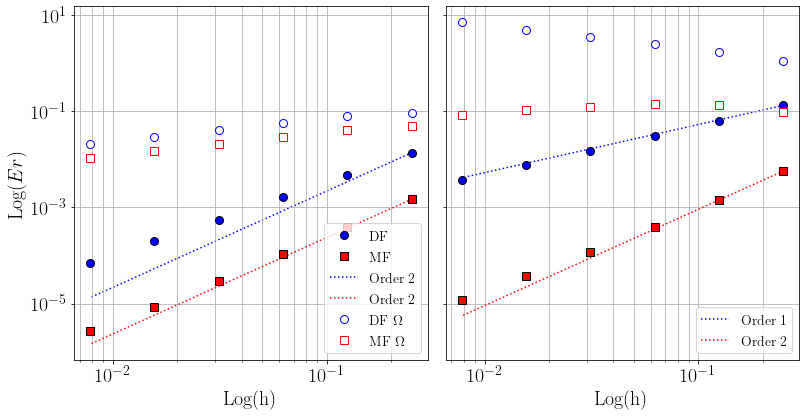

In [10]:
# Plot convergence rate
colors = ["blue", "red"]

fig, axi = plt.subplots(1,2,figsize=(13,8),sharey="all",sharex="all")
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = axi[0]
ax.loglog( h, errs_L2_u_df, 'o', color='black', markerfacecolor=colors[0],
            linewidth=1.0, markersize=8.0, label=r"DF", zorder=2 ) 
ax.loglog( h, errs_L2_u_mf, 's', color='black', markerfacecolor=colors[1],
            linewidth=1.0, markersize=8.0, label=r"MF", zorder=4 ) 
ax.loglog( h, np.power(h/h[0], k_df+1)*1.0*errs_L2_u_df[0], color=colors[0],
            linestyle='dotted', label="Order {0}".format(k_df+1), zorder=1 )
ax.loglog( h, np.power(h/h[0], k_df+1)*1.0*errs_L2_u_mf[0], color=colors[1],
            linestyle='dotted', label="Order {0}".format(k_df+1), zorder=3 )
ax.loglog( h, errs_L2_u_df_domain, 'o', color=colors[0], markerfacecolor='w',
            linewidth=1.0, markersize=8.0, label=r"DF $\Omega$", zorder=5 ) 
ax.loglog( h, errs_L2_u_mf_domain, 's', color=colors[1], markerfacecolor='w',
            linewidth=1.0, markersize=8.0, label=r"MF $\Omega$", zorder=6 ) 
#ax.set_ylim((1e-7, 1e1))
ax.tick_params( )
ax.legend( loc="lower right" )
ax.grid( which='both' )
ax.set_xlabel( "Log(h)" )
ax.set_ylabel( r"Log($Er$)" )
ax.set_box_aspect(1)

ax = axi[1]
ax.loglog( h, errs_E_sigma_df, 'o', color='black', markerfacecolor=colors[0],
            linewidth=1.0, markersize=8.0, zorder=2 ) 
ax.loglog( h, errs_E_sigma_mf, 's', color='black', markerfacecolor=colors[1],
            linewidth=1.0, markersize=8.0, zorder=4 )
ax.loglog( h, np.power(h/h[0], k_df)*1.0*errs_E_sigma_df[0], color=colors[0],
            linestyle='dotted', label="Order {0}".format(k_df), zorder=1 )
ax.loglog( h, np.power(h/h[0], k_mf)*1.0*errs_E_sigma_mf[0], color=colors[1],
            linestyle='dotted', label="Order {0}".format(k_mf), zorder=3 )
ax.loglog( h, errs_E_sigma_df_domain, 'o', color=colors[0], markerfacecolor='w',
            linewidth=1.0, markersize=8.0, zorder=5 ) 
ax.loglog( h, errs_E_sigma_mf_domain, 's', color=colors[1], markerfacecolor='w',
            linewidth=1.0, markersize=8.0, zorder=6 )
#ax.set_ylim((1e-7, 1e1))
ax.tick_params( )
ax.legend( loc="lower right" )
ax.grid( which='both' )
ax.set_xlabel( "Log(h)" )
ax.set_box_aspect(1)

plt.show()